In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pysparkling import *
import h2o

ss = SparkSession.builder.getOrCreate()
conf = H2OConf().setLogLevel("ERRR") # TRACE,DEBUG,INFO,WARN,ERRR,FATAL
hc = H2OContext.getOrCreate(conf)


22/03/02 22:34:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/02 22:34:27 WARN InternalH2OBackend: Increasing 'spark.locality.wait' to value 0 (Infinitive) as we need to ensure we run on the nodes with H2O


Connecting to H2O server at http://192.168.0.166:54329 ... successful.


H2O_cluster_uptime:,10 secs
H2O_cluster_timezone:,Pacific/Pitcairn
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.3
H2O_cluster_version_age:,"14 days, 4 hours and 43 minutes"
H2O_cluster_name:,sparkling-water-dwoodbridge_local-1646289266836
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,798 Mb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.36.0.3-1-3.2
 * H2O name: sparkling-water-dwoodbridge_local-1646289266836
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,192.168.0.166,54327)
  ------------------------

  Open H2O Flow in browser: http://192.168.0.166:54329 (CMD + click in Mac OSX)

    


## Create H2OFrames

In [2]:
def toDoubleSafe(v):
    try:
        return float(v)
    except:
        return str(v) #if it is not a float type return as a string.
    
adultschema = StructType([
    StructField("age",DoubleType(),True),
    StructField("workclass",StringType(),True),
    StructField("fnlwgt",DoubleType(),True),
    StructField("education",StringType(),True),
    StructField("marital_status",StringType(),True),
    StructField("occupation",StringType(),True),
    StructField("relationship",StringType(),True),
    StructField("race",StringType(),True),
    StructField("sex",StringType(),True),
    StructField("capital_gain",DoubleType(),True),
    StructField("capital_loss",DoubleType(),True),
    StructField("hours_per_week",DoubleType(),True),
    StructField("native_country",StringType(),True),
    StructField("income",StringType(),True)
])

#load and convert the data
census_raw = ss.sparkContext.textFile("../Data/adult.raw", 4).map(lambda x:  x.split(", "))
census_raw = census_raw.map(lambda row:  [toDoubleSafe(x) for x in row])

dfraw = ss.createDataFrame(census_raw, adultschema)

adult_h2o = hc.asH2OFrame(dfraw, "adult")


In [3]:
adult_h2o.show()

age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
49,Private,160187,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
52,Self-emp-not-inc,209642,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
31,Private,45781,Masters,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
42,Private,159449,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## Split Dataframe

In [4]:
splitted_adult = adult_h2o.split_frame([0.8], seed=1) # seed : Set a seed for reproducibility
adult_train_h2o = splitted_adult[0]
adult_valid_h2o =  splitted_adult[1]

## Apply AutoML

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/automl/autoh2o.html

http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.automl.autoh2o.H2OAutoML


### Identify predictors and response

In [5]:
from h2o.automl import H2OAutoML
model_automl = H2OAutoML(max_models = 10, 
                         max_runtime_secs = 120, 
                         seed = 1, 
                         nfolds = 5) # seed : Set a seed for reproducibility

In [7]:
predictors = adult_valid_h2o.names[:]
response = "income"
predictors.remove(response)

model_automl.train(x=predictors,
                   y=response,
                   training_frame=adult_train_h2o)

AutoML progress: |
22:34:45.616: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_3_AutoML_1_20220302_223445

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.07403557037505269
RMSE: 0.2720947819695422
LogLoss: 0.23560792371514794
Null degrees of freedom: 10045
Residual degrees of freedom: 10041
Null deviance: 11065.317288154041
Residual deviance: 4733.834403284753
AIC: 4743.834403284753
AUC: 0.9520514667439164
AUCPR: 0.87707028570398
Gini: 0.9041029334878328

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36599830174951065: 


,<=50K,>50K,Error,Rate
<=50K,6946.0,692.0,0.0906,(692.0/7638.0)
>50K,435.0,1973.0,0.1806,(435.0/2408.0)
Total,7381.0,2665.0,0.1122,(1127.0/10046.0)



Maximum Metrics: Maximum metrics at their respective thresholds


metric,threshold,value,idx
max f1,0.3659983,0.7778435,206.0
max f2,0.1736286,0.8462393,285.0
max f0point5,0.5880660,0.8112333,126.0
max accuracy,0.4571706,0.8938881,169.0
max precision,0.9971789,1.0,0.0
max recall,0.0024085,1.0,396.0
max specificity,0.9971789,1.0,0.0
max absolute_mcc,0.3659983,0.7046800,206.0
max min_per_class_accuracy,0.2973278,0.8745745,233.0
max mean_per_class_accuracy,0.2893889,0.8757754,237.0



Gains/Lift Table: Avg response rate: 23.97 %, avg score: 24.01 %


group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
1,0.0100538,0.9960378,4.1719269,4.1719269,1.0,0.9969585,1.0,0.9969585,0.0419435,0.0419435,317.1926910,317.1926910,0.0419435
2,0.0200080,0.9943186,4.1719269,4.1719269,1.0,0.9951950,1.0,0.9960811,0.0415282,0.0834718,317.1926910,317.1926910,0.0834718
3,0.0300617,0.9912991,4.1719269,4.1719269,1.0,0.9927819,1.0,0.9949778,0.0419435,0.1254153,317.1926910,317.1926910,0.1254153
4,0.0400159,0.9861559,4.1719269,4.1719269,1.0,0.9889874,1.0,0.9934876,0.0415282,0.1669435,317.1926910,317.1926910,0.1669435
5,0.0500697,0.9768920,4.1719269,4.1719269,1.0,0.9820812,1.0,0.9911973,0.0419435,0.2088870,317.1926910,317.1926910,0.2088870
6,0.1000398,0.7967399,3.8893661,4.0307871,0.9322709,0.8840185,0.9661692,0.9376612,0.1943522,0.4032392,288.9366124,303.0787094,0.3987878
7,0.1500100,0.6566727,3.2993127,3.7871241,0.7908367,0.7282134,0.9077638,0.8678916,0.1648671,0.5681063,229.9312716,278.7124096,0.5499078
8,0.2000796,0.4998539,2.4633445,3.4558499,0.5904573,0.5733620,0.8283582,0.7941859,0.1233389,0.6914452,146.3344518,245.5849903,0.6462763
9,0.3000199,0.3040048,1.7576943,2.8901737,0.4213147,0.3946324,0.6927671,0.6610898,0.1756645,0.8671096,75.7694306,189.0173653,0.7458737
10,0.4000597,0.1534951,0.9008041,2.3927075,0.2159204,0.2258194,0.5735258,0.5522451,0.0901163,0.9572259,-9.9195881,139.2707521,0.7328216




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.08848399278631697
RMSE: 0.2974625905661365
LogLoss: 0.2779930191656141
Null degrees of freedom: 9712
Residual degrees of freedom: 9708
Null deviance: 10721.281934372493
Residual deviance: 5400.29239031122
AIC: 5410.29239031122
AUC: 0.9288870104826666
AUCPR: 0.8277924409544691
Gini: 0.8577740209653333

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39084786611875866: 


,<=50K,>50K,Error,Rate
<=50K,6676.0,699.0,0.0948,(699.0/7375.0)
>50K,578.0,1760.0,0.2472,(578.0/2338.0)
Total,7254.0,2459.0,0.1315,(1277.0/9713.0)



Maximum Metrics: Maximum metrics at their respective thresholds


metric,threshold,value,idx
max f1,0.3908479,0.7337920,199.0
max f2,0.1873095,0.8100838,282.0
max f0point5,0.6940349,0.7592447,99.0
max accuracy,0.4894190,0.8733656,163.0
max precision,0.9978796,1.0,0.0
max recall,0.0018137,1.0,397.0
max specificity,0.9978796,1.0,0.0
max absolute_mcc,0.3988571,0.6469472,195.0
max min_per_class_accuracy,0.2676474,0.8464500,248.0
max mean_per_class_accuracy,0.2188124,0.8481043,269.0



Gains/Lift Table: Avg response rate: 24.07 %, avg score: 24.01 %


group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
1,0.0100896,0.9958188,4.1544055,4.1544055,1.0,0.9969817,1.0,0.9969817,0.0419162,0.0419162,315.4405475,315.4405475,0.0419162
2,0.0200762,0.9934931,4.1544055,4.1544055,1.0,0.9947421,1.0,0.9958677,0.0414885,0.0834046,315.4405475,315.4405475,0.0834046
3,0.0300628,0.9896331,4.1544055,4.1544055,1.0,0.9916007,1.0,0.9944502,0.0414885,0.1248931,315.4405475,315.4405475,0.1248931
4,0.0400494,0.9830301,4.1115766,4.1437258,0.9896907,0.9868889,0.9974293,0.9925648,0.0410607,0.1659538,311.1576552,314.3725769,0.1658182
5,0.0500360,0.9722295,4.1115766,4.1373092,0.9896907,0.9783282,0.9958848,0.9897233,0.0410607,0.2070145,311.1576552,313.7309156,0.2067434
6,0.1000721,0.7864004,3.5987751,3.8680421,0.8662551,0.8727455,0.9310700,0.9312344,0.1800684,0.3870830,259.8775113,286.8042134,0.3779982
7,0.1500051,0.6555943,2.7924457,3.5100022,0.6721649,0.7218138,0.8448868,0.8615234,0.1394354,0.5265184,179.2445742,251.0002155,0.4958743
8,0.2000412,0.5085811,2.5046107,3.2585249,0.6028807,0.5858628,0.7843541,0.7925727,0.1253208,0.6518392,150.4610708,225.8524932,0.5950256
9,0.3000103,0.2983294,1.6557723,2.7244574,0.3985582,0.3962350,0.6557996,0.6605055,0.1655261,0.8173653,65.5772316,172.4457400,0.6813653
10,0.3999794,0.1565301,0.9669368,2.2851903,0.2327497,0.2244899,0.5500644,0.5515297,0.0966638,0.9140291,-3.3063195,128.5190347,0.6770121




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.08738780876294049
RMSE: 0.2956142905255774
LogLoss: 0.2749769105263207
Null degrees of freedom: 39128
Residual degrees of freedom: 39125
Null deviance: 43030.435255483266
Residual deviance: 21519.143063968804
AIC: 21527.143063968804
AUC: 0.9295262218511031
AUCPR: 0.8305962150737285
Gini: 0.8590524437022062

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36354361109695715: 


,<=50K,>50K,Error,Rate
<=50K,26618.0,3162.0,0.1062,(3162.0/29780.0)
>50K,2126.0,7223.0,0.2274,(2126.0/9349.0)
Total,28744.0,10385.0,0.1351,(5288.0/39129.0)



Maximum Metrics: Maximum metrics at their respective thresholds


metric,threshold,value,idx
max f1,0.3635436,0.7320361,213.0
max f2,0.1427813,0.8108386,303.0
max f0point5,0.6822876,0.7656467,105.0
max accuracy,0.4962866,0.8740320,165.0
max precision,0.9977381,1.0,0.0
max recall,0.0008702,1.0,399.0
max specificity,0.9977381,1.0,0.0
max absolute_mcc,0.4136845,0.6439664,194.0
max min_per_class_accuracy,0.2704283,0.8431918,250.0
max mean_per_class_accuracy,0.2338740,0.8453635,265.0



Gains/Lift Table: Avg response rate: 23.89 %, avg score: 23.89 %


group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
1,0.0100181,0.9962584,4.1853674,4.1853674,1.0,0.9973104,1.0,0.9973104,0.0419296,0.0419296,318.5367419,318.5367419,0.0419296
2,0.0200107,0.9939157,4.1853674,4.1853674,1.0,0.9951511,1.0,0.9962321,0.0418227,0.0837523,318.5367419,318.5367419,0.0837523
3,0.0300033,0.9908639,4.1746632,4.1818024,0.9974425,0.9924491,0.9991482,0.9949722,0.0417157,0.1254680,317.4663154,318.1802370,0.1254344
4,0.0400215,0.9856926,4.1426596,4.1720042,0.9897959,0.9885892,0.9968072,0.9933744,0.0415018,0.1669697,314.2659588,317.2004177,0.1668018
5,0.0500141,0.9757315,4.1532546,4.1682581,0.9923274,0.9808267,0.9959121,0.9908674,0.0415018,0.2084715,315.3254625,316.8258099,0.2082029
6,0.1000026,0.7866277,3.7082013,3.9382885,0.8859918,0.8778140,0.9409660,0.9343551,0.1853674,0.3938389,270.8201297,293.8288484,0.3860820
7,0.1500166,0.6465882,2.8700884,3.5821611,0.6857435,0.7178049,0.8558773,0.8621594,0.1435448,0.5373837,187.0088440,258.2161144,0.5089753
8,0.2000051,0.4993822,2.3473150,3.2735285,0.5608384,0.5726280,0.7821365,0.7897951,0.1173388,0.6547224,134.7314958,227.3528491,0.5974692
9,0.3000077,0.3026901,1.6514713,2.7328428,0.3945822,0.3927218,0.6529517,0.6574373,0.1651514,0.8198738,65.1471325,173.2842769,0.6830706
10,0.4000102,0.1543459,0.9872461,2.2964436,0.2358804,0.2249199,0.5486839,0.5493080,0.0987271,0.9186009,-1.2753865,129.6443611,0.6813947


## Leader Board

Reported on cross-validation data.

In [8]:
model_automl.leaderboard

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_3_AutoML_1_20220302_223445,0.929526,0.274977,0.830596,0.166791,0.295614,0.0873878
StackedEnsemble_AllModels_2_AutoML_1_20220302_223445,0.929522,0.275036,0.830636,0.168809,0.295621,0.0873919
StackedEnsemble_BestOfFamily_5_AutoML_1_20220302_223445,0.929014,0.284526,0.828456,0.165525,0.29692,0.0881612
StackedEnsemble_AllModels_1_AutoML_1_20220302_223445,0.928885,0.276381,0.829585,0.163404,0.296147,0.0877028
StackedEnsemble_AllModels_4_AutoML_1_20220302_223445,0.92882,0.278598,0.828885,0.171623,0.296003,0.0876177
StackedEnsemble_BestOfFamily_2_AutoML_1_20220302_223445,0.92859,0.27681,0.828951,0.163766,0.296432,0.0878717
GBM_3_AutoML_1_20220302_223445,0.928315,0.277869,0.828017,0.168082,0.296806,0.0880937
StackedEnsemble_AllModels_3_AutoML_1_20220302_223445,0.928239,0.276687,0.827981,0.173945,0.296524,0.0879265
StackedEnsemble_BestOfFamily_4_AutoML_1_20220302_223445,0.928185,0.276587,0.827767,0.171972,0.296484,0.0879026
GBM_2_AutoML_1_20220302_223445,0.927865,0.278652,0.827774,0.168311,0.296927,0.0881656


## Prediction

In [9]:
predictions = model_automl.predict(adult_valid_h2o)
predictions

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,<=50K,>50K
<=50K,0.98026,0.0197395
>50K,0.0143293,0.985671
>50K,0.15035,0.84965
<=50K,0.984314,0.0156857
>50K,0.375083,0.624917
<=50K,0.998887,0.00111345
>50K,0.420144,0.579856
>50K,0.149293,0.850707
<=50K,0.933865,0.0661352
>50K,0.524182,0.475818


## Explainability

In [10]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_3_AutoML_1_20220302_223445


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39084786611875866: 


,<=50K,>50K,Error,Rate
<=50K,6676.0,699.0,0.0948,(699.0/7375.0)
>50K,578.0,1760.0,0.2472,(578.0/2338.0)
Total,7254.0,2459.0,0.1315,(1277.0/9713.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

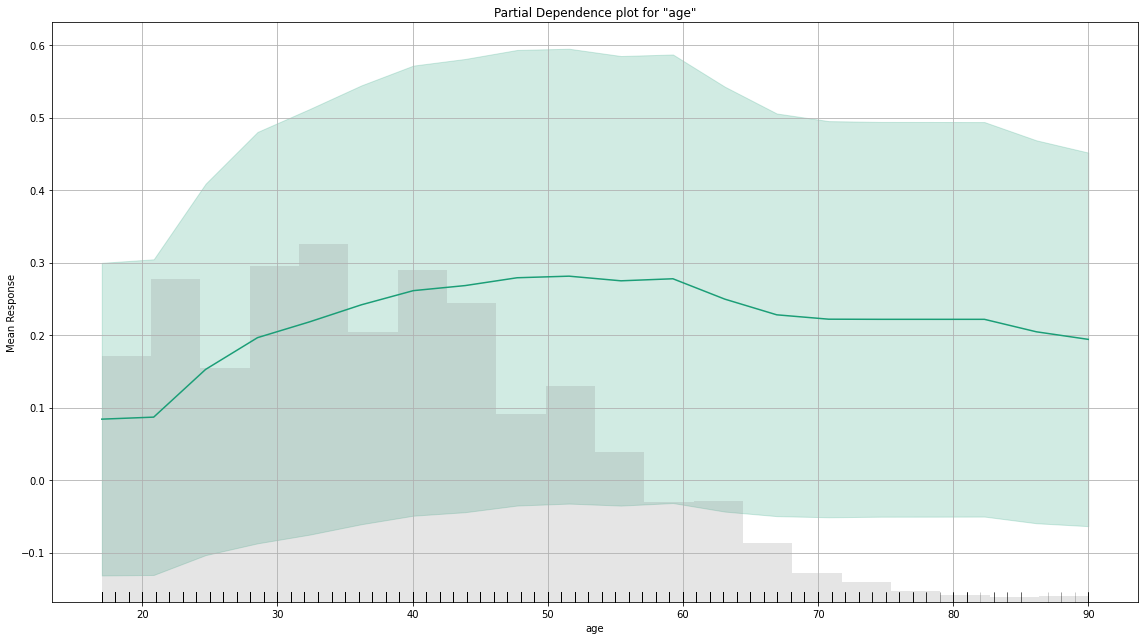

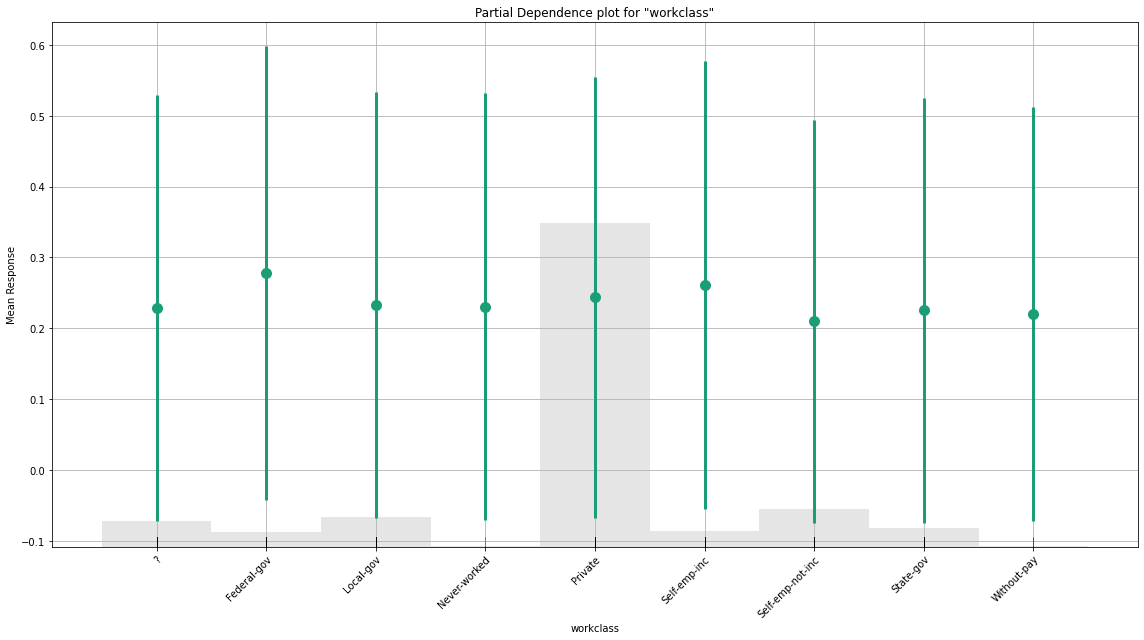

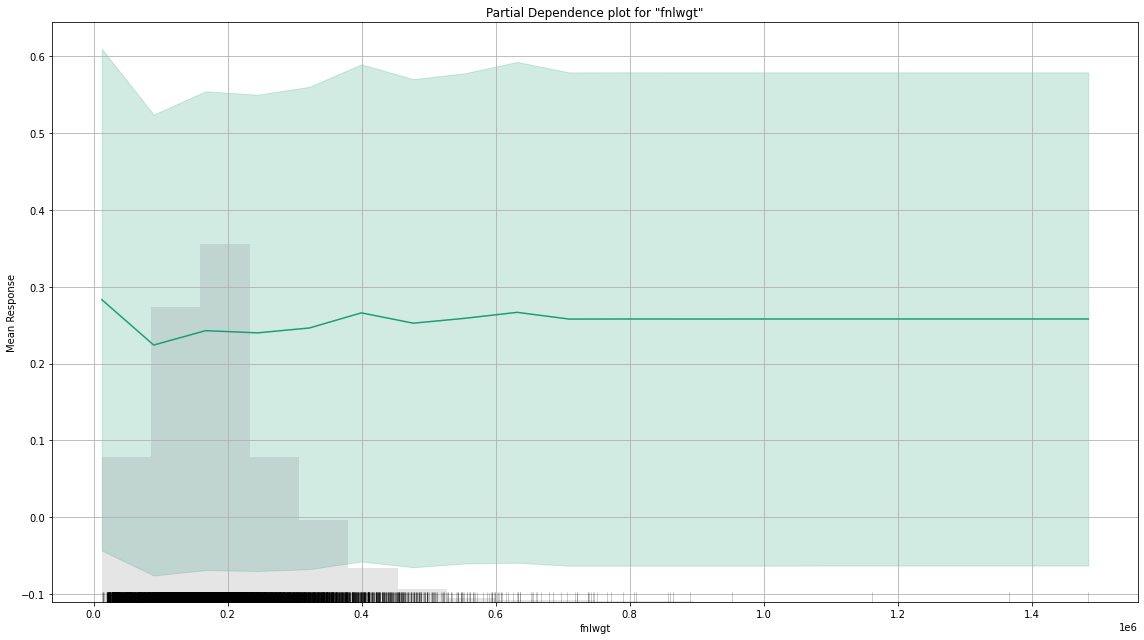

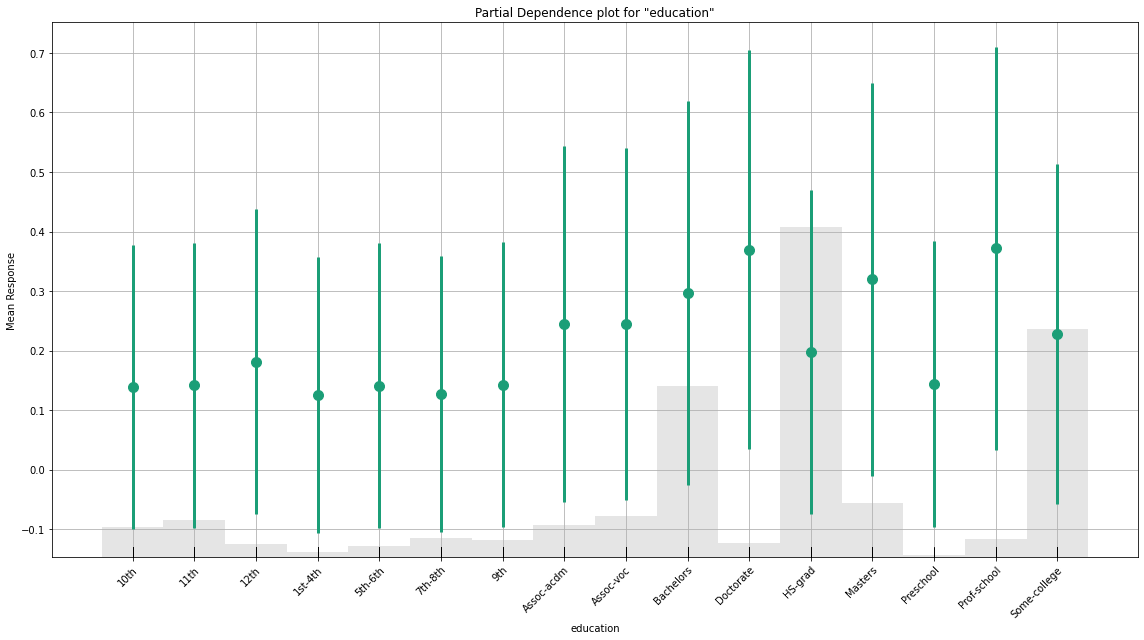

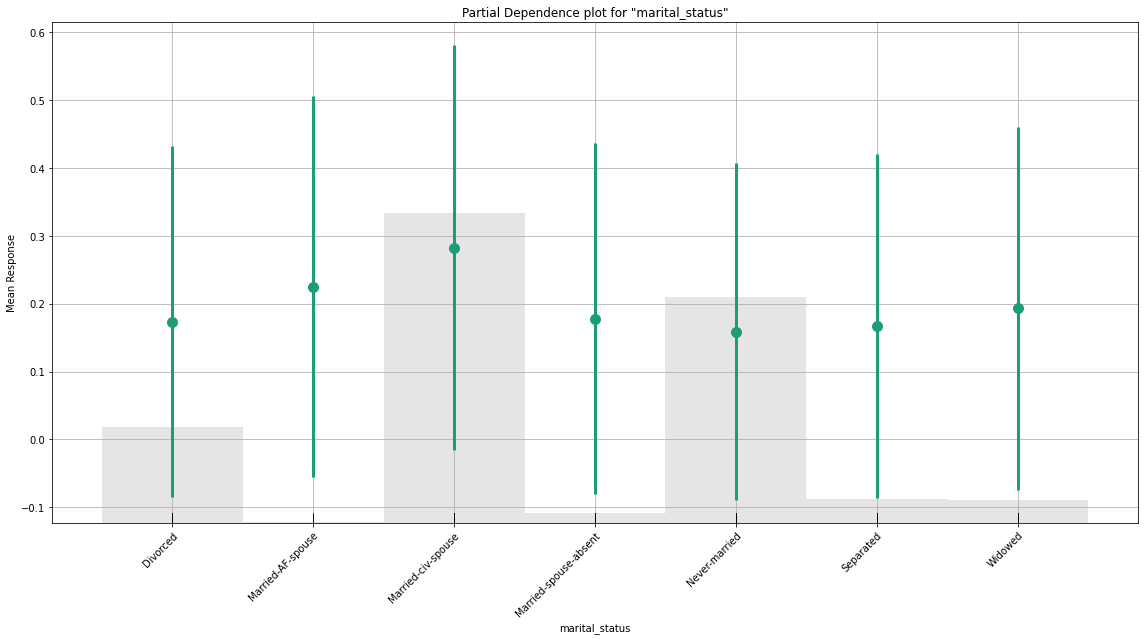

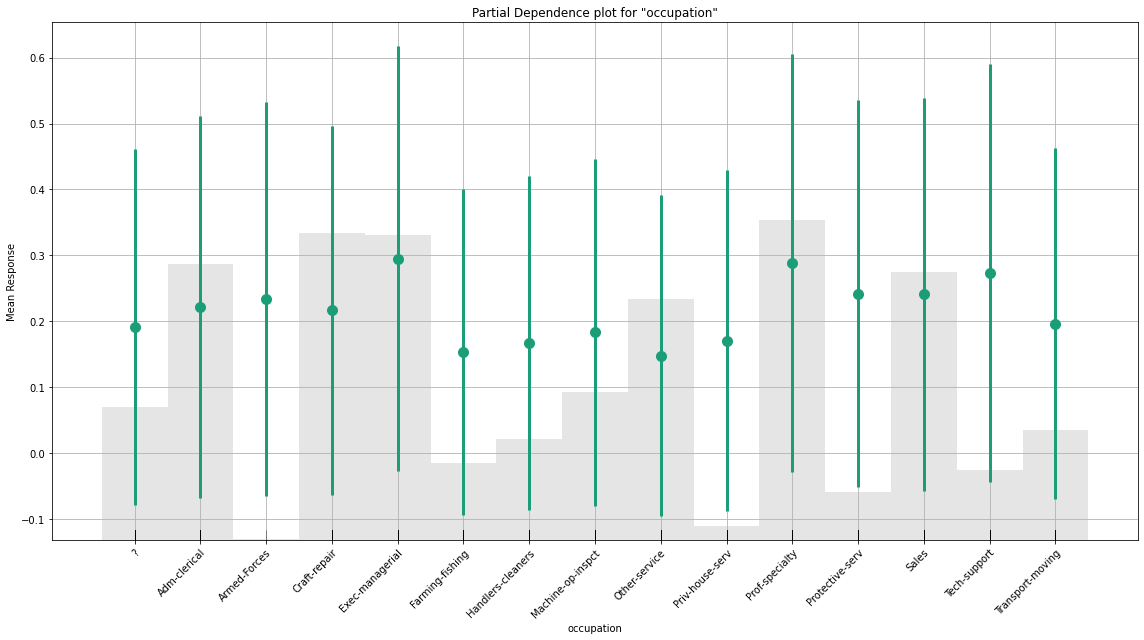

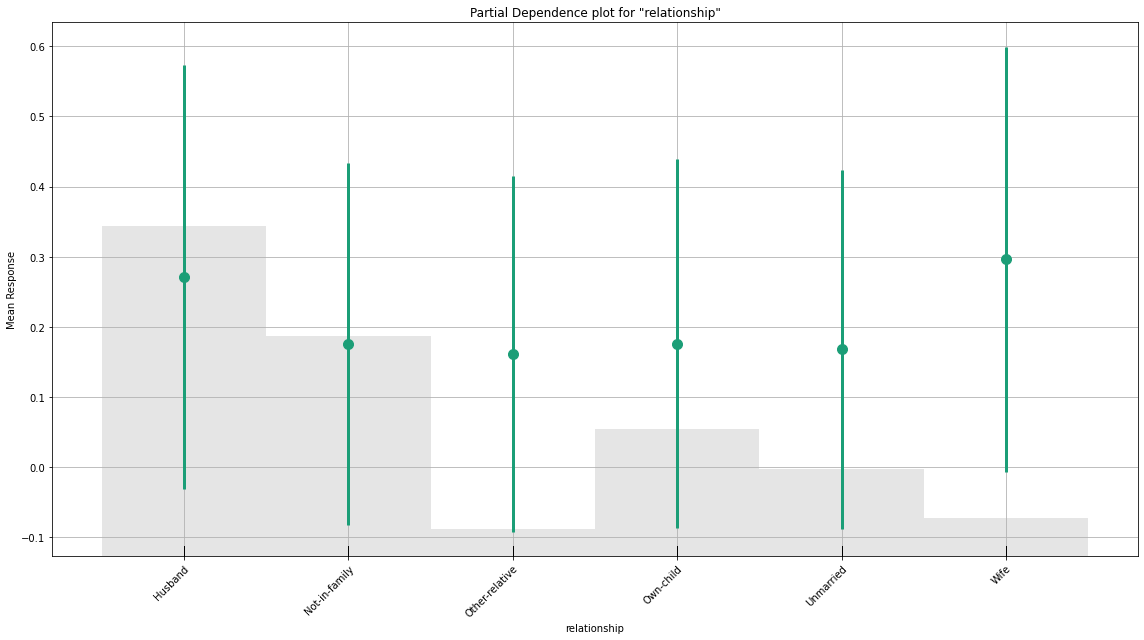

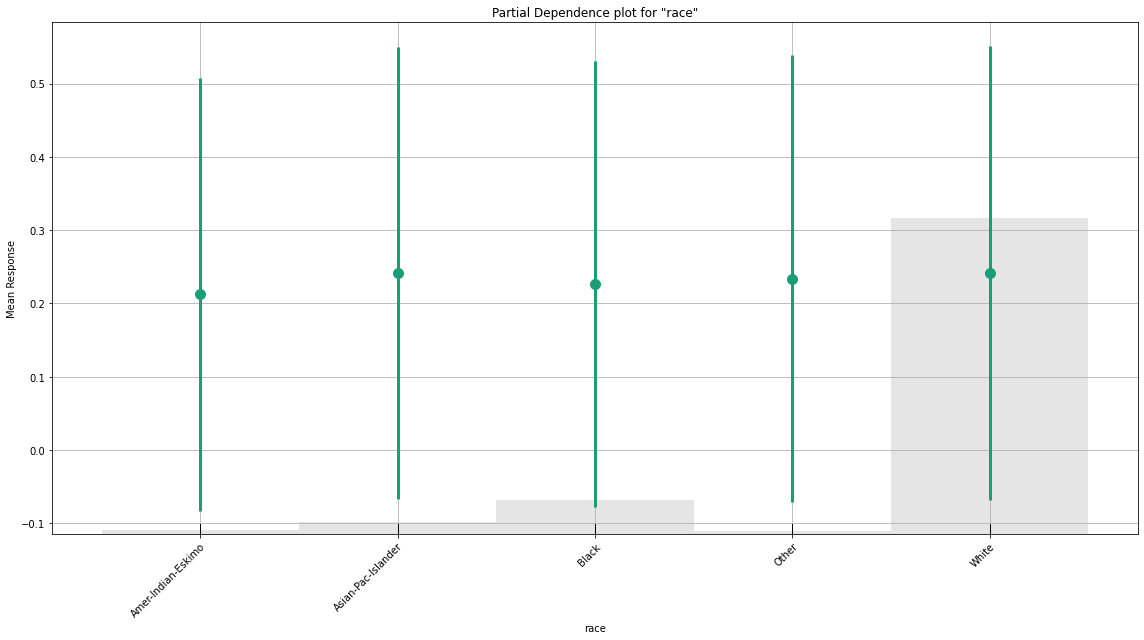

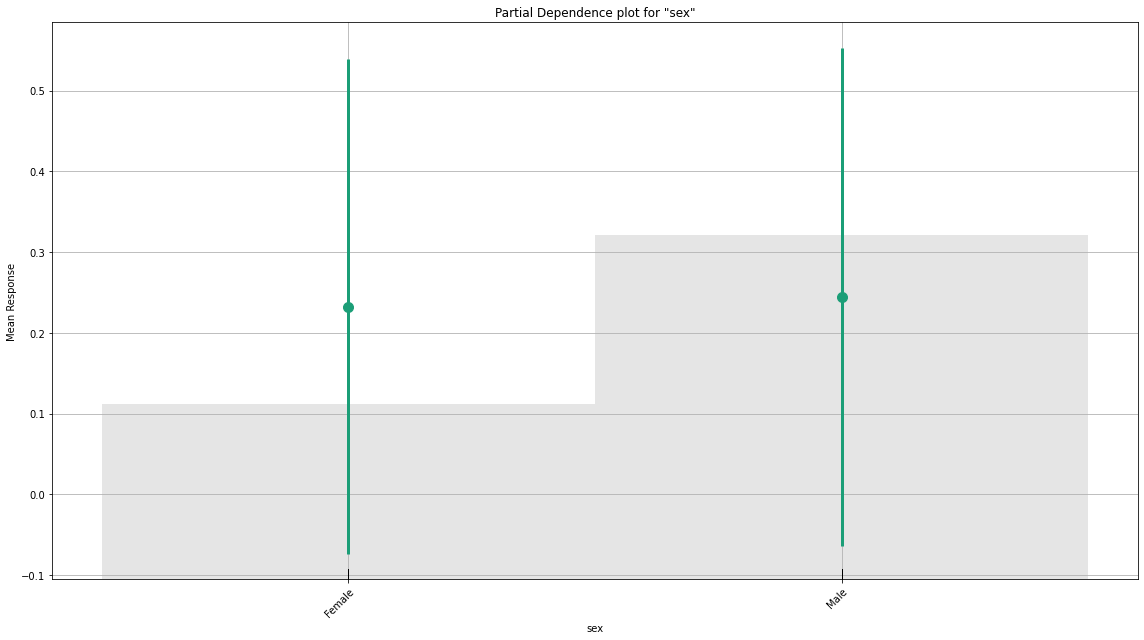

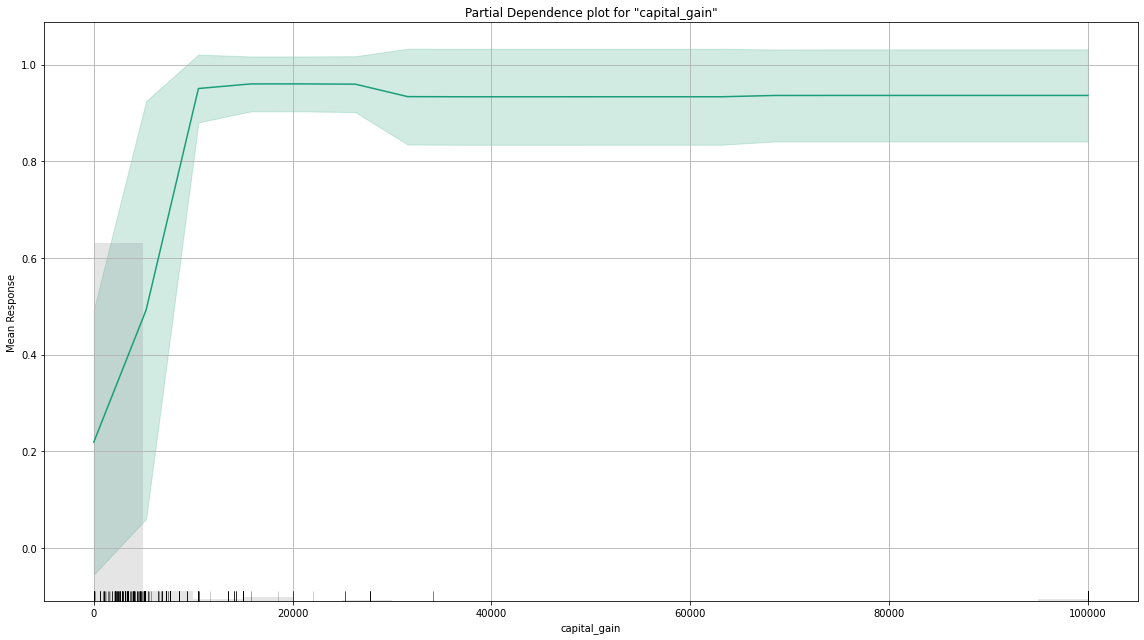

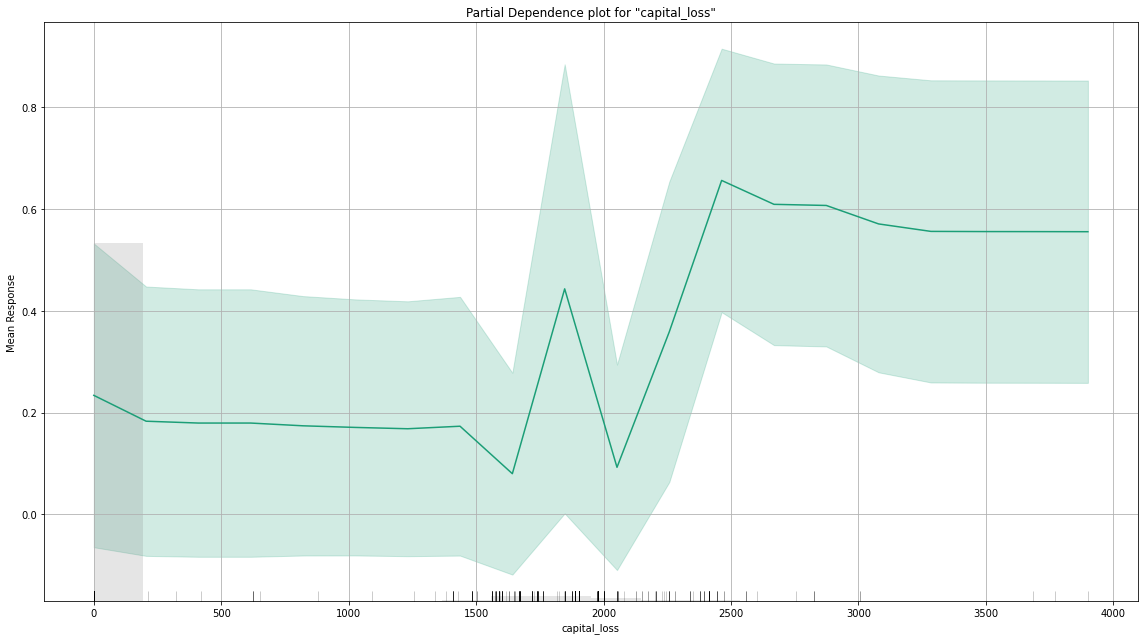

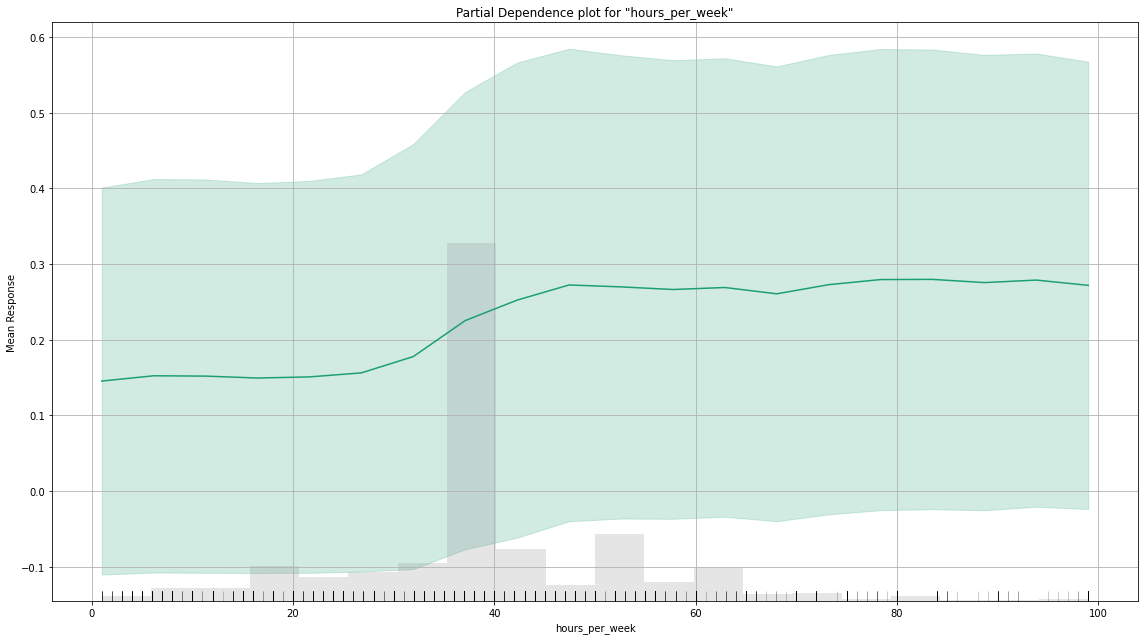

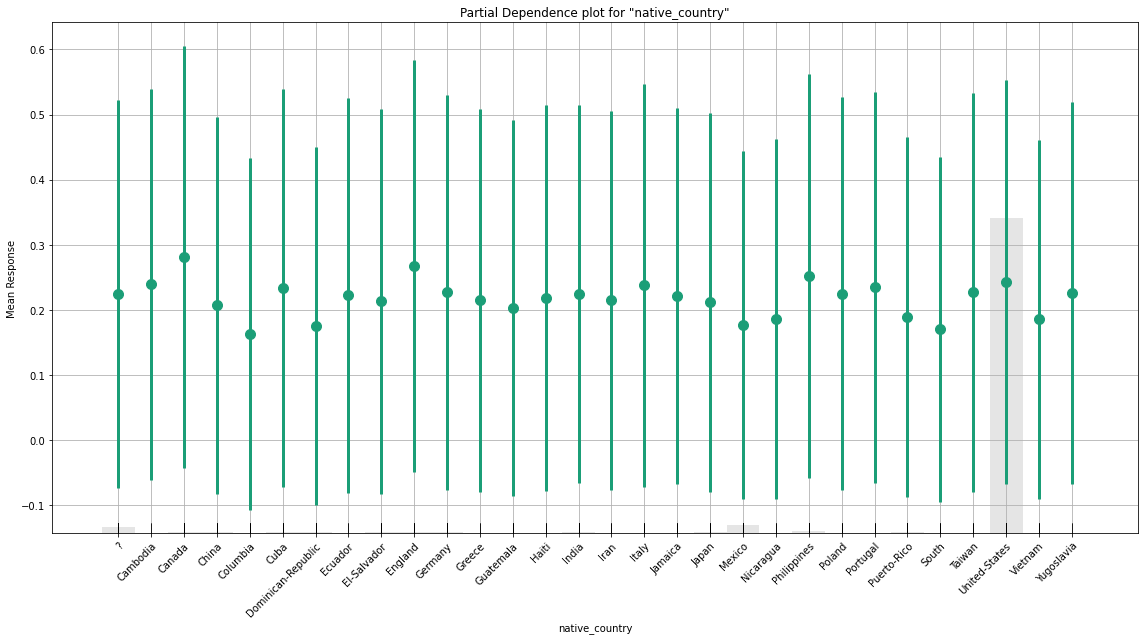

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_3_AutoML_1_20220302_223445


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39084786611875866: 


,<=50K,>50K,Error,Rate
<=50K,6676.0,699.0,0.0948,(699.0/7375.0)
>50K,578.0,1760.0,0.2472,(578.0/2338.0)
Total,7254.0,2459.0,0.1315,(1277.0/9713.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [11]:
import matplotlib_inline, matplotlib
model_automl.get_best_model().explain(adult_valid_h2o)

In [12]:
ss.stop()